In [426]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [427]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [428]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [429]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [430]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [431]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [432]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [433]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [434]:
master_data = master_data[132:]

In [435]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [436]:
master_data.reset_index(inplace=True)

In [437]:
master_data = master_data.drop(labels='index', axis=1)

In [438]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [439]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [440]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [441]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [442]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [443]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [444]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [445]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [446]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [447]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [448]:
master_data.to_csv('master_data.csv')

In [449]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

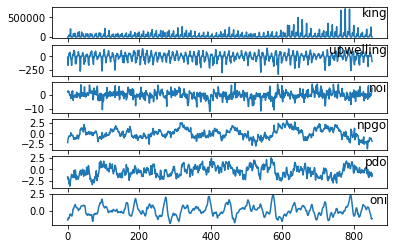

In [450]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [451]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [452]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [453]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [454]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
8/8 - 2s - loss: 0.0312 - root_mean_squared_error: 0.1766 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2395
Epoch 2/1000
8/8 - 0s - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0438 - val_root_mean_squared_error: 0.2093
Epoch 3/1000
8/8 - 0s - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1981
Epoch 4/1000
8/8 - 0s - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1961
Epoch 5/1000
8/8 - 0s - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2005
Epoch 6/1000
8/8 - 0s - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1935
Epoch 7/1000
8/8 - 0s - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 8/1000
8/8 - 0s - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0356 - val_root_mea

Epoch 40/1000
8/8 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1787
Epoch 41/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1785
Epoch 42/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1784
Epoch 43/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1782
Epoch 44/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781
Epoch 45/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1779
Epoch 46/1000
8/8 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0840 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778
Epoch 47/1000
8/8 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0315 - val_

Epoch 79/1000
8/8 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1719
Epoch 80/1000
8/8 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1716
Epoch 81/1000
8/8 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1714
Epoch 82/1000
8/8 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712
Epoch 83/1000
8/8 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 84/1000
8/8 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1707
Epoch 85/1000
8/8 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1704
Epoch 86/1000
8/8 - 0s - loss: 0.0064 - root_mean_squared_error: 0.0797 - val_loss: 0.0290 - val_

Epoch 118/1000
8/8 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1604
Epoch 119/1000
8/8 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 120/1000
8/8 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1597
Epoch 121/1000
8/8 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0752 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1594
Epoch 122/1000
8/8 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1591
Epoch 123/1000
8/8 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1588
Epoch 124/1000
8/8 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1585
Epoch 125/1000
8/8 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.025

Epoch 157/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 158/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 159/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 160/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1478
Epoch 161/1000
8/8 - 0s - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 162/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 163/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1469
Epoch 164/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.021

Epoch 196/1000
8/8 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1362
Epoch 197/1000
8/8 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1358
Epoch 198/1000
8/8 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1354
Epoch 199/1000
8/8 - 0s - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 200/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1346
Epoch 201/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 202/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 203/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.017

Epoch 235/1000
8/8 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 236/1000
8/8 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 237/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 238/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 239/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0592 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 240/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177
Epoch 241/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 242/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.013

Epoch 274/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 275/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 276/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 277/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 278/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 279/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 280/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 281/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0545 - val_loss: 0.011

Epoch 313/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0967
Epoch 314/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 315/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 316/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0515 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 317/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 318/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955
Epoch 319/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 320/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.009

Epoch 352/1000
8/8 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 353/1000
8/8 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 354/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0485 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 355/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877
Epoch 356/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875
Epoch 357/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 358/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 359/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.007

Epoch 391/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811
Epoch 392/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810
Epoch 393/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 394/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806
Epoch 395/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 396/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0803
Epoch 397/1000
8/8 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 398/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.006

Epoch 430/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 431/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750
Epoch 432/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 433/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746
Epoch 434/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 435/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742
Epoch 436/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0740
Epoch 437/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.005

Epoch 469/1000
8/8 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0711
Epoch 470/1000
8/8 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0743
Epoch 471/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 472/1000
8/8 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 473/1000
8/8 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 474/1000
8/8 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 475/1000
8/8 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784
Epoch 476/1000
8/8 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.006

Epoch 508/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 509/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
Epoch 510/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 511/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 512/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 513/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 514/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 515/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.004

Epoch 547/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 548/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 549/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 550/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 551/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 552/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0381 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 553/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 554/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.003

Epoch 586/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 587/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 588/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 589/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 590/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 591/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 592/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 593/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.003

Epoch 625/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 626/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 627/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 628/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 629/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 630/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570
Epoch 631/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 632/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.003

Epoch 664/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 665/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 666/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 667/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 668/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 669/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 670/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 671/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.002

Epoch 703/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 704/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 705/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 706/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 707/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 708/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 709/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 710/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.002

Epoch 741/1000
8/8 - 0s - loss: 9.9817e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 742/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 743/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 744/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 745/1000
8/8 - 0s - loss: 9.7355e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 746/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 747/1000
8/8 - 0s - loss: 9.8044e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 748/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0322 - val

8/8 - 0s - loss: 9.8624e-04 - root_mean_squared_error: 0.0314 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 780/1000
8/8 - 0s - loss: 9.1789e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 781/1000
8/8 - 0s - loss: 8.7242e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 782/1000
8/8 - 0s - loss: 8.4387e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 783/1000
8/8 - 0s - loss: 9.0460e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 784/1000
8/8 - 0s - loss: 9.9138e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 785/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 786/1000
8/8 - 0s - loss: 9.0971e-04 - root_mean_squared_error: 0.0302 - va

Epoch 817/1000
8/8 - 0s - loss: 9.0077e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 818/1000
8/8 - 0s - loss: 8.3663e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 819/1000
8/8 - 0s - loss: 8.9042e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 820/1000
8/8 - 0s - loss: 8.6450e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 821/1000
8/8 - 0s - loss: 7.7968e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 822/1000
8/8 - 0s - loss: 8.2020e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 823/1000
8/8 - 0s - loss: 8.7989e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 824/1000
8/8 - 0s - loss: 8.4571e-04 - root_mean_squared

Epoch 855/1000
8/8 - 0s - loss: 8.2182e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 856/1000
8/8 - 0s - loss: 7.1959e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 857/1000
8/8 - 0s - loss: 7.2529e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 858/1000
8/8 - 0s - loss: 7.2296e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 859/1000
8/8 - 0s - loss: 7.1560e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 860/1000
8/8 - 0s - loss: 7.8284e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 861/1000
8/8 - 0s - loss: 8.8353e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 862/1000
8/8 - 0s - loss: 7.5569e-04 - root_mean_squared

Epoch 893/1000
8/8 - 0s - loss: 6.8212e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 894/1000
8/8 - 0s - loss: 6.8751e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 895/1000
8/8 - 0s - loss: 7.0025e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 896/1000
8/8 - 0s - loss: 7.8850e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 897/1000
8/8 - 0s - loss: 7.0531e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 898/1000
8/8 - 0s - loss: 7.4991e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0381
Epoch 899/1000
8/8 - 0s - loss: 6.9764e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 900/1000
8/8 - 0s - loss: 6.6155e-04 - root_mean_squared

Epoch 931/1000
8/8 - 0s - loss: 8.3113e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 932/1000
8/8 - 0s - loss: 9.6266e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 933/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 934/1000
8/8 - 0s - loss: 8.8811e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 935/1000
8/8 - 0s - loss: 9.5490e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 936/1000
8/8 - 0s - loss: 8.6896e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 937/1000
8/8 - 0s - loss: 8.2492e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 938/1000
8/8 - 0s - loss: 9.1933e-04 - root_mean_squared_err

Epoch 969/1000
8/8 - 0s - loss: 5.5552e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 970/1000
8/8 - 0s - loss: 5.4448e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 971/1000
8/8 - 0s - loss: 5.5418e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 972/1000
8/8 - 0s - loss: 6.2532e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 973/1000
8/8 - 0s - loss: 7.0696e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 974/1000
8/8 - 0s - loss: 5.8880e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 975/1000
8/8 - 0s - loss: 5.7173e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 976/1000
8/8 - 0s - loss: 5.6544e-04 - root_mean_squared

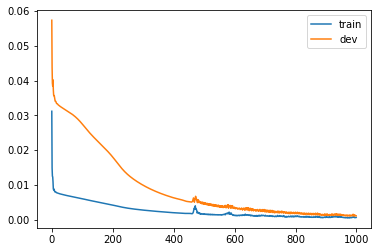

In [455]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(SimpleRNN(50, return_sequences=True))
# model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(1))
# model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=100, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [456]:
# make a prediction
yhat = model.predict(test_X)
train_yhat = model.predict(train_X)


In [457]:
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))
train_X = train_X.reshape((train_X.shape[0], n_months*n_features))

In [458]:
# invert scaling for forecast
inv_yhat_train = concatenate((train_yhat, train_X[:, -5:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, -5:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [459]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [460]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

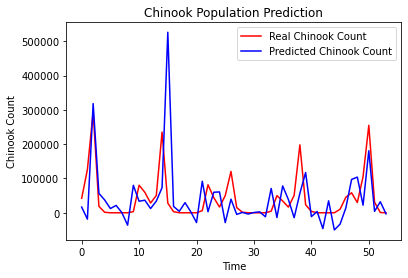

The test root mean squared error is 87677.129880032.


In [461]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

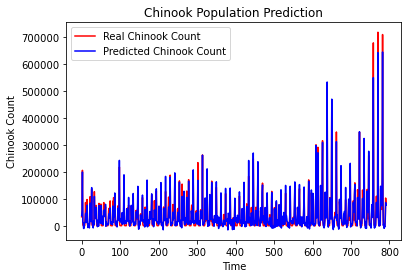

The test root mean squared error is 17301.78071760245.


In [462]:
plot_predictions(inv_y_train, inv_yhat_train)
return_rmse(inv_y_train, inv_yhat_train)

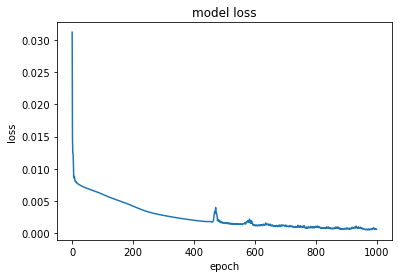

In [463]:
plot_loss(history)

In [464]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  805148
1  223192
2  318407
3  357216
    Count
0  488981
1  336030
2  381773
3  535746


In [465]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [466]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [467]:
return_rmse(actual, preds)

The test root mean squared error is 192731.806527231.
